In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

# Load models

In [7]:
env_name = "ShaftInsertion/"
model_name = "MHGP-BDI/"
iter = "0/3/"

lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/" + env_name + model_name + iter + "learner.pickle"
# lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/ShaftInsertion/20211116_BDI_shaft_insertion/learner.pickle"
# lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/ShaftInsertion/20211115_BDI_shaft_insertion/MHGP-BDI/0/1/learner.pickle"

lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/ShaftInsertion/20211116_BDI_shaft_insertion/3/MHGP-BDI/0/1/learner.pickle"
lnr = torch.load(lnr_path)
learner = lnr["learner"]

## state
relative coordinations
- S: shaft
- G: gripper
- State = [(S-G1)[X,Y,Z], (S-G2)[X,Y,Z]]
    - X: horizontal left-right
    - Y: horizontal up-down
    - Z: vertical up-down

In [23]:
# Starting point of end effector
    # (end-effector)
    #     x: -0.5909129532489867
    #     y: 0.39471475958372093
    #     z: 0.39175792915985286
    # (shaftC)
    #     x: -0.5918293595314026
    #     y: 0.3821650743484497
    #     z: 0.3343000113964081
starting_position_Sc = np.array([-0.592, 0.382, 0.334])
holeA_position = lnr["learner"].X[0][:3] + starting_position_Sc
holeB_position = lnr["learner"].X[0][3:6] + starting_position_Sc

shaftC_position = holeA_position - lnr["learner"].X[0][:3]
print("HoleA: ",holeA_position)
print("HoleB: ",holeB_position)

HoleA:  tensor([-0.5124,  0.2012,  0.0891], dtype=torch.float64)
HoleB:  tensor([-0.7055,  0.1937,  0.0899], dtype=torch.float64)


### Visualization area

- X-axis: shaft_A_x - 0.1[m] <= X <= shaft_A_x + 0.1[m]
- Y-axis: shaft_A_y
- Z-axis: shaft_A_z - 0.1[m] <= Z <= shaft_A_z + 0.4[m]

In [34]:
Ha_x, Ha_y, Ha_z = holeA_position
Hb_x, Hb_y, Hb_z = holeB_position
Sc_x, Sc_y, Sc_z = starting_position_Sc
scale = 1
x_range = np.array([Sc_x - 0.15*scale, Sc_x + 0.15*scale])
y_range = np.array(Ha_y)-0.02
z_range = np.array([Ha_z - 0.1*scale, Ha_z + 0.25*scale])


In [35]:
print("X: ", x_range)
print("Y: ", y_range)
print("Z: ", z_range)
print("Hole A: ", holeA_position)
print("Hole B: ", holeB_position)

X:  [-0.742 -0.442]
Y:  0.18120766830444338
Z:  [-0.01086837  0.33913163]
Hole A:  tensor([-0.5124,  0.2012,  0.0891], dtype=torch.float64)
Hole B:  tensor([-0.7055,  0.1937,  0.0899], dtype=torch.float64)


In [36]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time

In [37]:
def get_traj_fig(dir_fig=str, fig_name=str):
    # No grid line 
    plt.grid(color = 'grey',alpha=0.1)
    # plt.grid(color = 'grey',alpha=0.0)
    # back ground image
    im = plt.imread("Data/Figures/shaft_insertion_env.png")
    plt.imshow(im, extent=[x_range[0],x_range[1], z_range[0],z_range[1]],alpha=1.0)

    xticks = torch.linspace(float(x_range[0]),float(x_range[1]), steps=3)
    zticks = torch.linspace(float(z_range[0]),float(z_range[1]), steps=3)

    plt.xticks(xticks,alpha=1.0)
    plt.yticks(zticks,alpha=1.0)
    plt.xlabel("X",fontsize=15,labelpad=1)
    plt.ylabel("Z",fontsize=15, labelpad=1)
    plt.savefig(dir_fig + fig_name + '.png',transparent=True)
    # plt.savefig(dir_fig + fig_name + '.pdf')

def get_dpoints_plt(dataset, color="b"):
    """dataset = [N , 2]"""
    # X, Y = dataset[:,0], dataset[:,1]
    X, Y = dataset[:,0][::3], dataset[:,1][::3]
    plt.scatter(X, Y, c=color, s=100, alpha=0.1, marker = 's')

## 3D-scatter datapoints

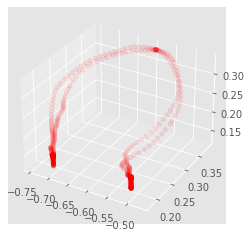

In [38]:
States = learner.X

dataPoints = -(States[:,:3]-holeA_position)
xs, ys, zs = dataPoints[:,0], dataPoints[:,1], dataPoints[:,2]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=xs, ys=ys, zs=zs, marker='o', alpha =0.1, color='r')

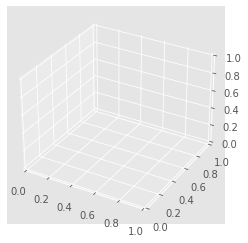

In [39]:
_,_, disturbance = learner.predict(S)

D = (disturbance **2).sum(1).sqrt()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# for i in range(xs.shape[0]):
#     ax.scatter(xs=xs[i], ys=ys[i], zs=zs[i], marker='o', alpha =float(D[i]), color='r')

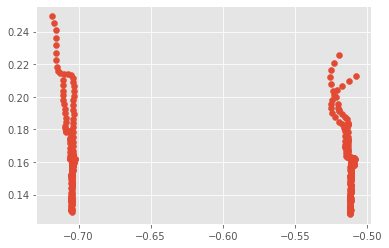

In [40]:
plt.scatter(x=xs[ys<0.2],y=zs[ys<0.2])

## Heat-map of disturbance level

### Dummy data: end-effctor position -> state
- state: 
    - [0:3] HoleA - shaftC
    - [3:6] HoleB - shaftC

In [41]:
# make these smaller to increase the resolution
res = 0.01
# generate 2 2d grids for the x & y bounds
Y, X = np.mgrid[slice(z_range[0],z_range[1] + res, res),
                slice(x_range[0],x_range[1] + res, res)]

Sc_positions = torch.tensor(np.vstack((X.flatten(), Y.flatten())).T)

state1 = torch.stack((Ha_x - Sc_positions[:,0],
        Ha_y.repeat(Sc_positions.shape[0])-y_range,
        Ha_z - Sc_positions[:,1])).T
state2 = torch.stack((Hb_x - Sc_positions[:,0],
        Hb_y.repeat(Sc_positions.shape[0])-y_range,
        Hb_z - Sc_positions[:,1])).T
S = torch.cat((state1,state2),axis=1)

_,_, disturbance = learner.predict(S)

D = (disturbance **2).sum(1).sqrt()

(36, 32)


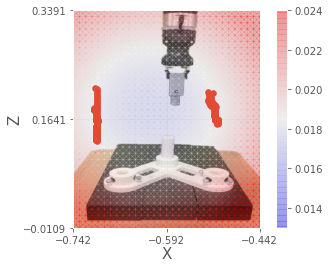

In [43]:
# x, y, z = X, Y, D.view(41,41)
print(X.shape)
x, y, z = X, Y, D.view(X.shape)

c = plt.pcolormesh(x, y, z, cmap='bwr', vmin=0.013, vmax=0.024,alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='bwr', alpha=0.2,shading='gouraud')

plt.colorbar(c)
plt.scatter(x=xs[ys<0.19],y=zs[ys<0.19])

get_traj_fig(dir_fig="Data/Result/Disturbance_visualization/Disturbance_map/shaft_insertion/", fig_name='state_dependent'+ str(int(time.time())) )

In [51]:
s_x, s_y, s_z = -0.6, y_range, 0.1641
state1 = torch.tensor([Ha_x-s_x ,
        Ha_y-s_y,
        Ha_z - s_z])
state2 = torch.tensor([Hb_x-s_x ,
        Hb_y-s_y,
        Hb_z - s_z])
center_state = torch.cat((state1,state2))[None,:]

_,_, disturbance = learner.predict(center_state)
print(disturbance)

tensor([[0.0130, 0.0030, 0.0108]])


In [52]:
s_x, s_y, s_z = -0.7, y_range, 0.1641
state1 = torch.tensor([Ha_x-s_x ,
        Ha_y-s_y,
        Ha_z - s_z])
state2 = torch.tensor([Hb_x-s_x ,
        Hb_y-s_y,
        Hb_z - s_z])
center_state = torch.cat((state1,state2))[None,:]

_,_, disturbance = learner.predict(center_state)
print(disturbance)

tensor([[0.0134, 0.0033, 0.0118]])


In [198]:
env_name = "ShaftInsertion/"
model_name = "MGP-BDI/"
iter = "0/1/"

lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/" + env_name + model_name + iter + "learner.pickle"
homo = torch.load(lnr_path)
homo_lnr = homo["learner"]
homo_noise = (np.exp(homo_lnr.log_sigma[len(homo_lnr.K) - 1]))
print(homo_noise)
homo_noise_level = (homo_noise **2).sum(0).sqrt()
print(homo_noise_level)

tensor([0.2078, 0.2074, 0.2076])
tensor(0.3596)


(62, 42)


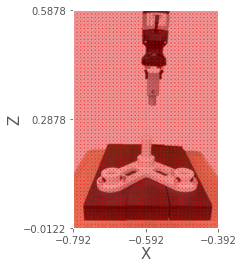

In [184]:
# x, y, z = X, Y, D.view(41,41)
print(X.shape)
x, y, z = X, Y, D.view(X.shape)
z = z/abs(z)
z *= homo_noise_level
z_min, z_max = z.min(), z.max()

# c = plt.pcolormesh(x, y, z, cmap='coolwarm', vmin=0.0, vmax=1.5, alpha=0.6)
c = plt.pcolormesh(x, y, z, cmap='bwr', vmin=0.017, vmax=0.05, alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='Reds', vmin=0.0, vmax=1.5, alpha=0.6)

# plt.colorbar(c)

get_traj_fig(dir_fig="Data/Result/Disturbance_visualization/Disturbance_map/", fig_name='state_independent'+ str(int(time.time())) )

# Relearning

In [20]:
from tools import (
    GaussianKernel,
    IOMHGP,
)
fkern = GaussianKernel()
gkern = GaussianKernel()
interval = 12
S = learner.X[::interval]
A = learner.Y[::interval]
M = 5
L = 10.0
re_learner = IOMHGP(S, A, fkern, gkern, M=M, lengthscale=L)
re_learner.learning(max_iter=20)

E step
M step
--------------------
fkern 1  :  tensor([1.5983])
fkern 2  :  tensor([1.5953])
fkern 3  :  tensor([1.6301])
fkern 4  :  tensor([1.5777])
fkern 5  :  tensor([1.5864])
gkern :  tensor([1.5974])
mu0 :  tensor([0.0098, 0.0098, 0.0098])
v_beta_0 :  tensor(102.5558)
1  th Marginalized VB :  tensor(188.9943, grad_fn=<NegBackward>)
Z :  tensor([30.8182, 11.9997,  2.9780,  0.1322,  0.0719])
E step
M step
--------------------
fkern 1  :  tensor([1.6386])
fkern 2  :  tensor([1.5953])
fkern 3  :  tensor([1.6301])
fkern 4  :  tensor([1.5777])
fkern 5  :  tensor([1.5864])
gkern :  tensor([1.6417])
mu0 :  tensor([0.0095, 0.0095, 0.0095])
v_beta_0 :  tensor(105.1762)
2  th Marginalized VB :  tensor(143.1708, grad_fn=<NegBackward>)
Z :  tensor([45.7854,  0.0547,  0.0540,  0.0533,  0.0526])
E step
M step
--------------------
fkern 1  :  tensor([1.6780])
fkern 2  :  tensor([1.5953])
fkern 3  :  tensor([1.6301])
fkern 4  :  tensor([1.5777])
fkern 5  :  tensor([1.5864])
gkern :  tensor([1.684

(36, 32)


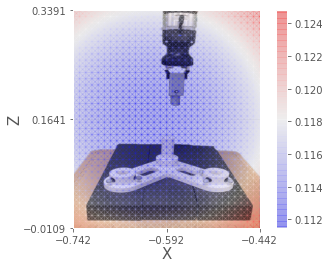

In [21]:
# make these smaller to increase the resolution
res = 0.01
# generate 2 2d grids for the x & y bounds
Y, X = np.mgrid[slice(z_range[0],z_range[1] + res, res),
                slice(x_range[0],x_range[1] + res, res)]

Sc_positions = torch.tensor(np.vstack((X.flatten(), Y.flatten())).T)

state1 = torch.stack((Ha_x - Sc_positions[:,0],
        Ha_y.repeat(Sc_positions.shape[0])-y_range,
        Ha_z - Sc_positions[:,1])).T
state2 = torch.stack((Hb_x - Sc_positions[:,0],
        Hb_y.repeat(Sc_positions.shape[0])-y_range,
        Hb_z - Sc_positions[:,1])).T
S = torch.cat((state1,state2),axis=1)

_,_, disturbance = re_learner.predict(S)

D = (disturbance **2).sum(1).sqrt()
# D = disturbance[:,2]

print(X.shape)
x, y, z = X, Y, D.view(X.shape)
c = plt.pcolormesh(x, y, z, cmap='bwr', alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='bwr',vmin=0.015,vmax=0.025, alpha=0.2,shading='gouraud')
plt.colorbar(c)
get_traj_fig(dir_fig="Data/Result/Disturbance_visualization/Disturbance_map/shaft_insertion/", fig_name='state_dependent'+ str(int(time.time())) )

In [22]:
print(state1, state2)

tensor([[ 0.2297,  0.0200,  0.1000],
        [ 0.2197,  0.0200,  0.1000],
        [ 0.2097,  0.0200,  0.1000],
        ...,
        [-0.0603,  0.0200, -0.2500],
        [-0.0703,  0.0200, -0.2500],
        [-0.0803,  0.0200, -0.2500]], dtype=torch.float64) tensor([[ 0.0366,  0.0125,  0.1008],
        [ 0.0266,  0.0125,  0.1008],
        [ 0.0166,  0.0125,  0.1008],
        ...,
        [-0.2534,  0.0125, -0.2492],
        [-0.2634,  0.0125, -0.2492],
        [-0.2734,  0.0125, -0.2492]], dtype=torch.float64)
